In [1]:
# !pip install --upgrade google-auth google-auth-oauthlib google-auth-httplib2
# !pip install -U seaborn matplotlib pandas numpy scipy

In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install pyreadstat
#!sudo apt-get remove fonts-nanum

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#한글처리
plt.rc('font',family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SW기술자_평균임금_20230321145714.csv', encoding='cp949')
df.head()
#SW종사사 하루(Day) 측정 임금
#11라인 결측치있음.

,직무별,2019,2020,2021
0,IT기획자,403081,388724,360307
1,IT컨설턴트,437900,458818,484732
2,정보보호컨설턴트,340978,342406,347123
3,업무분석가,501090,532243,548550
4,데이터분석가,335799,347670,323184


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#결측치 처리
df = df.replace('-', np.NaN)
data=df[['직무별','2019','2020','2021']]
imputer=KNNImputer(n_neighbors=5)
data[['2019']]=imputer.fit_transform(data[['2019']])
#11번째 결측치 처리함
data['2019'] = data['2019'].apply(lambda x: int(x))
rdf = data.copy()#데이터프레임을 복사해서 따로보관할것.

In [6]:
#admit:평균
data['admit'] = data.iloc[:,1:4].mean(axis=1)
data['admit'] = data['admit'].apply(lambda x: int(x))

In [7]:
data['합계'] = data.iloc[:,1:4].sum(axis=1)
data.head()

,직무별,2019,2020,2021,admit,합계
0,IT기획자,403081,388724,360307,384037,1152112
1,IT컨설턴트,437900,458818,484732,460483,1381450
2,정보보호컨설턴트,340978,342406,347123,343502,1030507
3,업무분석가,501090,532243,548550,527294,1581883
4,데이터분석가,335799,347670,323184,335551,1006653


array([[<Axes: title={'center': '2019'}>,
        <Axes: title={'center': '2020'}>],
       [<Axes: title={'center': '2021'}>,
        <Axes: title={'center': 'admit'}>],
       [<Axes: title={'center': '합계'}>, <Axes: >]], dtype=object)

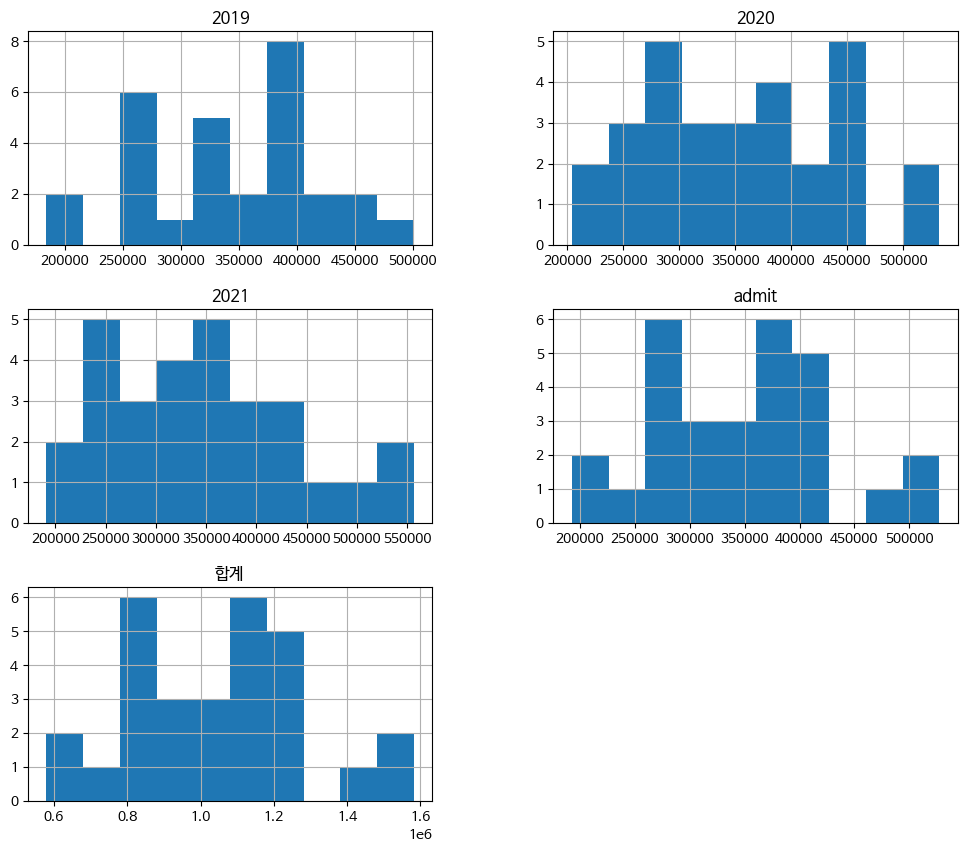

In [8]:
mpl.rcParams['figure.figsize'] = (12, 10)
data.hist()

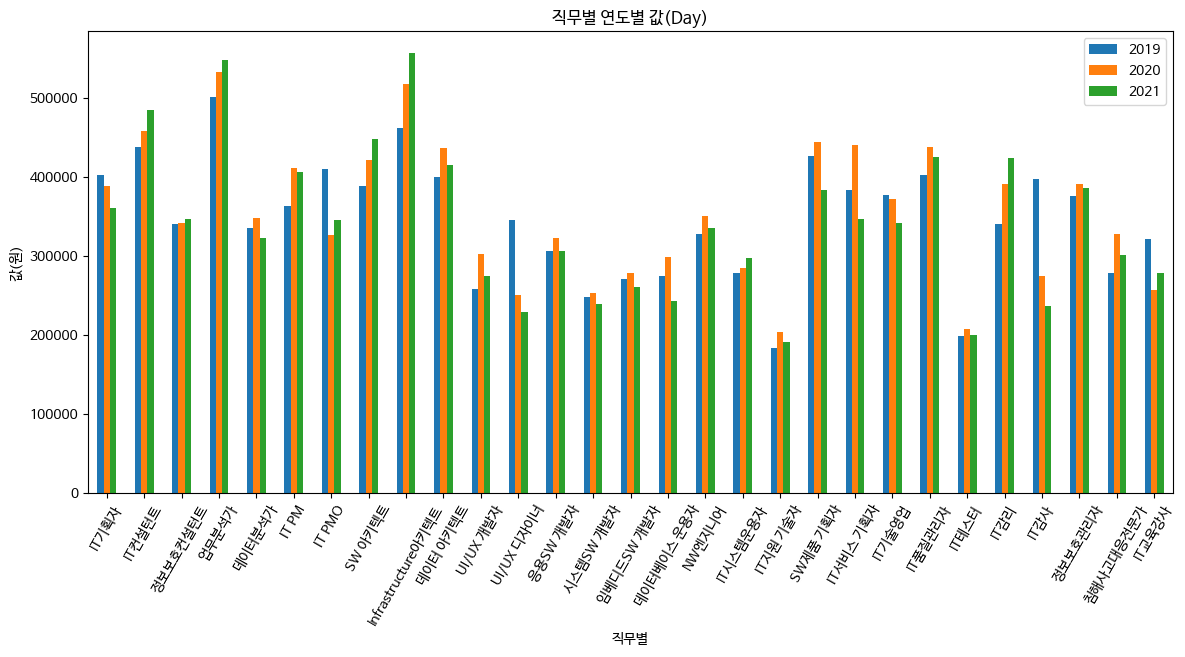

In [9]:
#3년치 시각화
mpl.rcParams['figure.figsize'] = (14, 6)
data.plot(x='직무별', y=['2019', '2020', '2021'], kind='bar')
plt.xticks(rotation=60)
plt.xlabel('직무별')
plt.ylabel('값(원)')
plt.title('직무별 연도별 값(Day)')
plt.show()

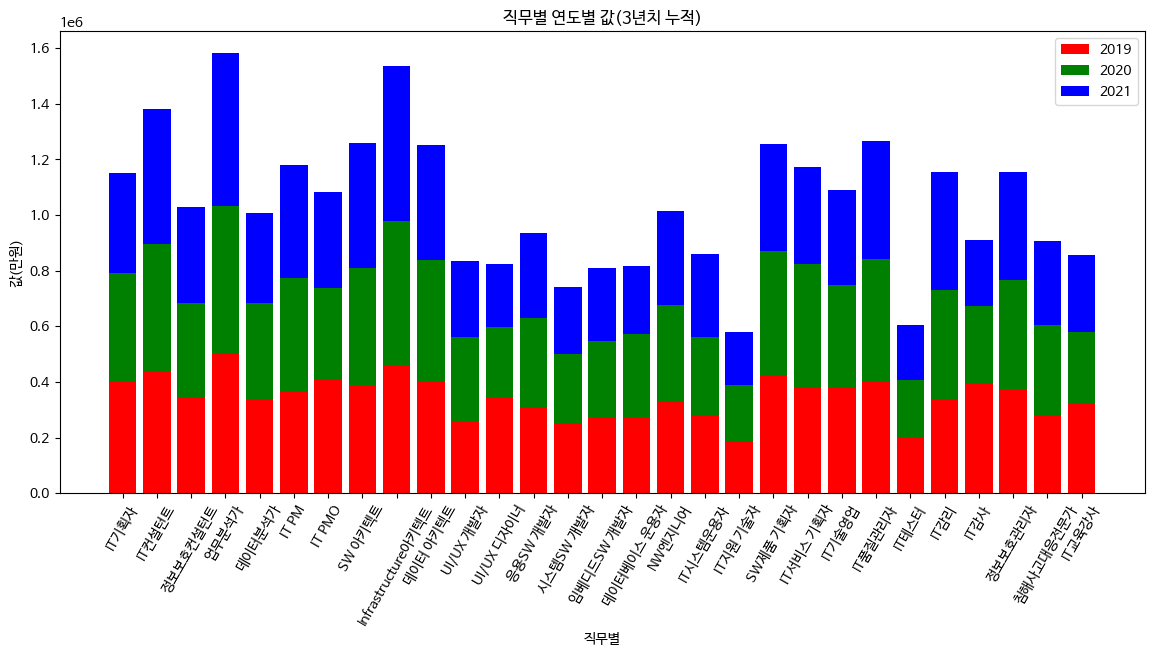

In [10]:
#3년치 누적
data_cumsum = data.iloc[:, 1:].cumsum(axis=1)
plt.figure(figsize=(14, 6))
plt.bar(data['직무별'], data['2019'], label='2019', color='red')
plt.bar(data['직무별'], data['2020'], label='2020', color='green', bottom=data_cumsum['2019'])
plt.bar(data['직무별'], data['2021'], label='2021', color='blue', bottom=data_cumsum['2020'])
plt.xticks(rotation=60)
plt.xlabel('직무별')
plt.ylabel('값(만원)')
plt.title('직무별 연도별 값(3년치 누적)')
plt.legend()
plt.show()

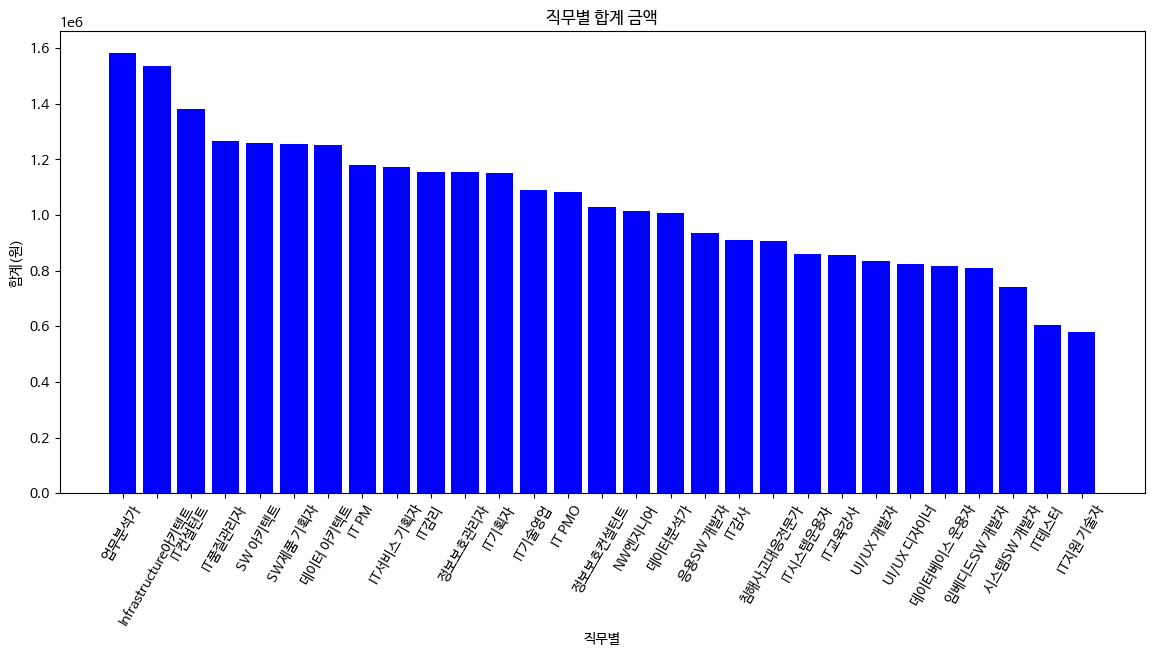

In [11]:
#가장 시급이 높은 직업군 오름차순 정렬하기
data_sorted = data.sort_values('합계', ascending=False)
plt.figure(figsize=(14, 6))
plt.bar(data_sorted['직무별'], data_sorted['합계'],color='blue')
plt.xticks(rotation=60)
plt.xlabel('직무별')
plt.ylabel('합계(원)')
plt.title('직무별 합계 금액')
plt.show()

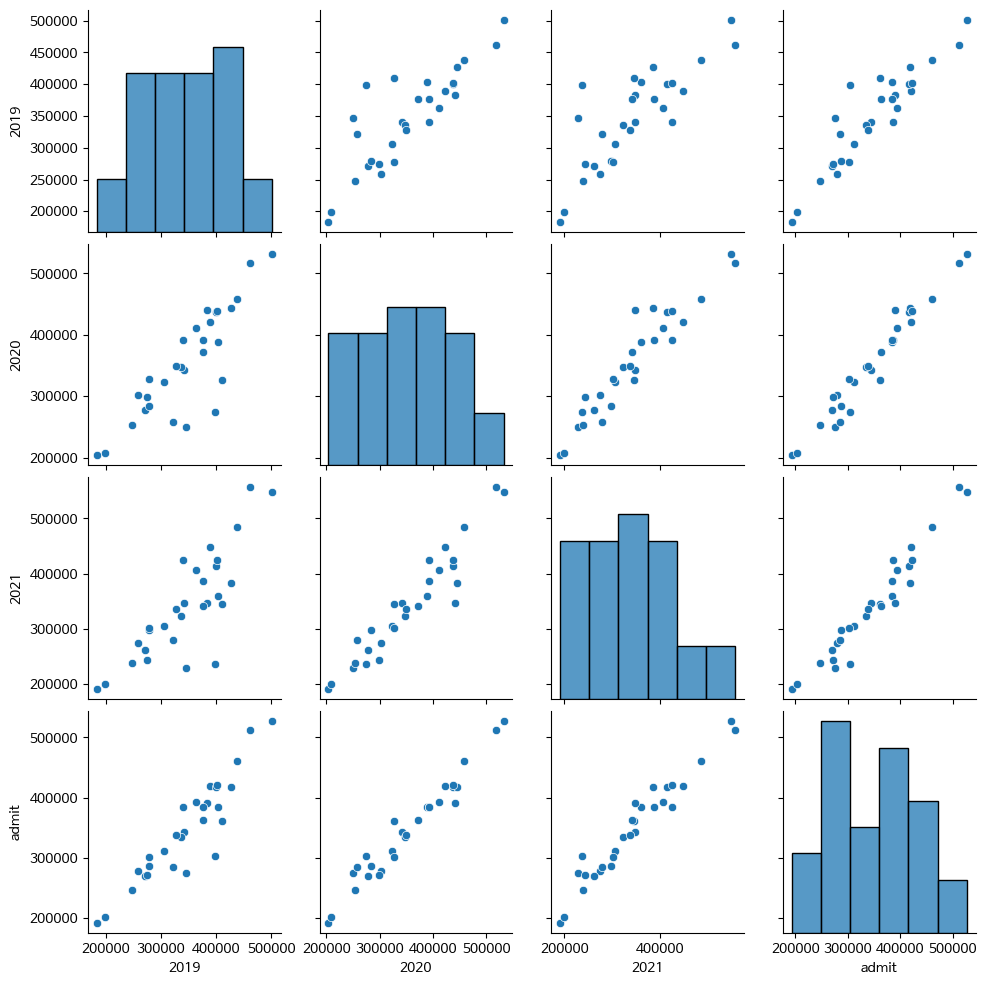

In [12]:
#순수 데이터 분석
df = data[['2019', '2020', '2021','admit']]
df=sns.pairplot(df)
plt.show()

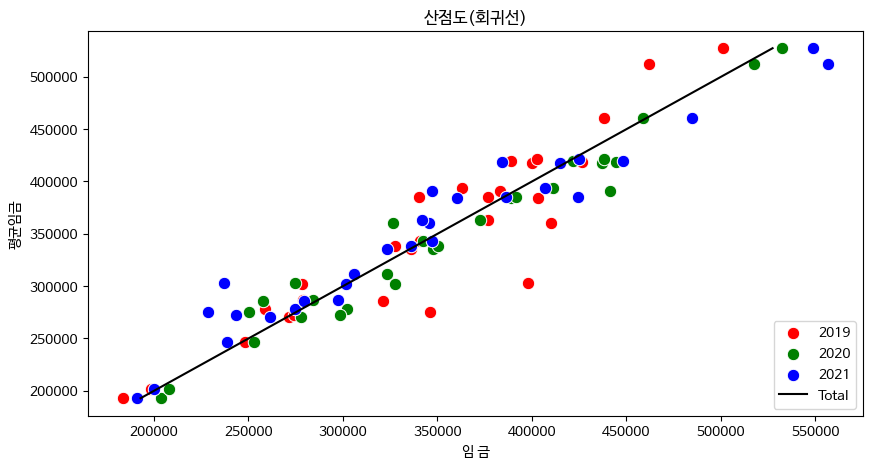

In [13]:
#순수 데이터 분석-산점도(회귀선)
df = data[['2019', '2020', '2021','admit']]
mpl.rcParams['figure.figsize'] = (10, 5) #import matplotlib as mpl
sns.scatterplot(data=df, x='2019', y='admit',s=80, color='red')
sns.scatterplot(data=df, x='2020', y='admit',s=80, color='green')
sns.scatterplot(data=df, x='2021', y='admit',s=80, color='blue')
sns.lineplot(data=df, x='admit', y='admit', color='black')
plt.legend(labels=['2019', '2020', '2021', 'Total'], loc='lower right')
plt.title('산점도(회귀선)')
plt.xlabel('임 금')
plt.ylabel('평균임금')
plt.show()

In [14]:
#데이터셋 분리
# X=df.loc[:,['2019','2020','2021']].values
# y=df['admit'].values
X=df.loc[:,['2019','2020']].values
y=df['2021'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
#정규화
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [15]:
#회귀분석-'평균으로 수렴'
#2019, 2020, 2021을 입력으로, admit을 타겟으로 하는 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)
print('테스트 모델 Score:',model.score(X_test,y_test))

테스트 모델 Score: 0.942322226279986


In [16]:
#검증용 데이터를 사용하여 모델 성능 평가
y_pred = model.predict(X_test)
r2score = r2_score(y_test, y_pred)
print('R-squared:', r2score)
#R-squared(결정계수) 값을 계산합니다. 
#R-squared 값은 0에서 1 사이의 값을 가지며,1에 가까울수록 모델의 성능이 우수함

R-squared: 0.942322226279986


In [17]:
print('기울기:',model.coef_)
print('y절편:',model.intercept_)

기울기: [0.05842467 0.96728583]
y절편: -21009.11523507256


In [18]:
#2023년 값을 예측1
prediction = model.predict([[321017, 257614]])[0]
#321017	257614	279165
print("*예측값:", round(prediction, 2))

*예측값: 246932.57


In [19]:
#2023년 값을 예측2
prediction = model.predict([[501090, 532243]])[0]
#501090	532243	548550
print("*예측값:", round(prediction, 2))

*예측값: 523098.01


In [20]:
#복사해둔 'rdf'데이터 프레임을 이용-MLP다층퍼셉트론,하이퍼파라미터 튜닝
df=rdf
df.drop('직무별', axis=1, inplace=True)

In [21]:
################################
#<MLP다층퍼셉트론>회귀 모델 구성
################################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
X = df.drop('2021', axis=1)  # 독립변수
y = df['2021']  # 종속변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)
model = Sequential()
model.add(Dense(200, input_dim=X.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()
# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=10,verbose=0)
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print("MSE:", score)
#입력값 예시
input_data = [[501090,532243]]
#501090	532243	548550
output_datar = model.predict(input_data)
#결과 출력
print("예측값: {:.2f}".format(output_datar[0][0]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               600       
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 25,801
Trainable params: 25,801
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 156ms/step - loss: 535116128.0000
MSE: 535116128.0
1/1 [==============================] - 0s 53ms/step
예측값: 516888.59


In [22]:
##############################
#<MLPRegressor & GridSearchCV>
##############################
from sklearn.metrics import r2_score
#입력 변수와 출력 변수 나누기
X = df.drop("2021", axis=1)
y = df["2021"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42,)
model = MLPRegressor()
#하이퍼파라미터 그리드 생성
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
    'alpha': [0.0001, 0.001, 0.01]
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search.best_params_)
#모델 평가
train_score = grid_search.score(X_train, y_train)
test_score = grid_search.score(X_test, y_test)
print(f"Train Score: {train_score:.2f}")
print(f"Test Score: {test_score:.2f}")
#예측값 출력
y_pred = grid_search.predict(X_test)
print("Predicted values: ", y_pred)
r2_score = r2_score(y_test, y_pred)
print(f"R2 Score: {r2_score:.2f}")
#입력값 예시
input_data = [[501090,532243]]
#501090	532243	548550
output_data = grid_search.predict(input_data)
#결과 출력
print(f"예측값: {output_data[0]:.2f}")

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Train Score: 0.78
Test Score: 0.87
Predicted values:  [293446.91787362 333639.08566783 310323.03886437 412778.97189383
 478481.91156795 410679.91532014]
R2 Score: 0.87
예측값: 509227.19


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [24]:
############ 3가지 결과값 비교 ############
print("1.선형회귀:", round(prediction, 2))
print("2.MLP다층퍼셉트론: {:.2f}".format(output_datar[0][0]))
print(f"3.MLPRegressor&GridSearchCV: {output_data[0]:.2f}")
print('4.실제값:548550')

1.선형회귀: 523098.01
2.MLP다층퍼셉트론: 516888.59
3.MLPRegressor&GridSearchCV: 509227.19
4.실제값:548550
